<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C4W4_3_Daily_min_temp_Conv1D_Multi_LSTM_Dense_Lambda_Huber_learning_rate_mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-26 02:25:17--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2020-04-26 02:25:17 (96.1 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
np.array(range(3))

array([0, 1, 2])

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(range(len(temps)))

time

array([   0,    1,    2, ..., 3647, 3648, 3649])

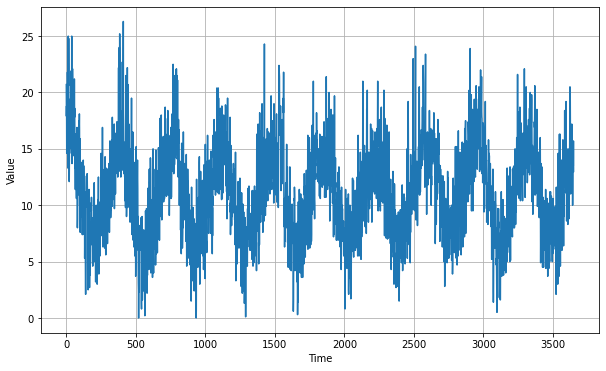

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 17ms/step - loss: 6.7689 - mae: 7.2628 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 6.7727 - mae: 7.2614 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 6.7684 - mae: 7.2592 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 20ms/step - loss: 6.7863 - mae: 7.2566 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 6.7441 - mae: 7.2535 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 6.7610 - mae: 7.2501 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 19ms/step - loss: 6.7624 - mae: 7.2462 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 21ms/step - loss: 6.7433 - mae: 7.2418 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 6.7516 - mae: 7.2369 - lr: 2.5

(1e-08, 0.0001, 0.0, 60.0)

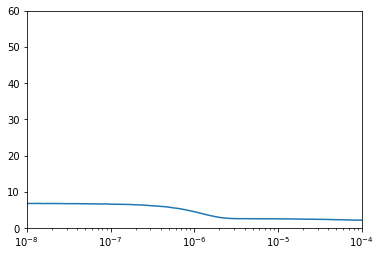

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [0]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 31.1706 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 26ms/step - loss: 30.5228 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.6681 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 28.6311 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 27.1851 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 25ms/step - loss: 25.5237 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 23.2871 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 27ms/step - loss: 20.5082 - mae: 21.1108 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 24ms/step - loss: 17.1935 - mae:

(1e-08, 0.0001, 0.0, 60.0)

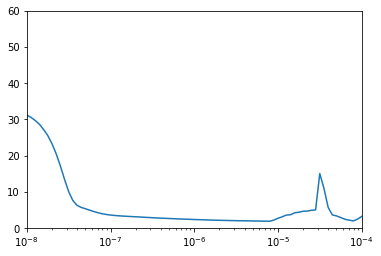

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()                                    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS
history = model.fit(train_set, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 14ms/step - loss: 12.3573 - mae: 13.0702
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 2.6504 - mae: 3.1246
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 1.9989 - mae: 2.4529
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 1.8933 - mae: 2.3467
Epoch 5/100
25/25 [==============================] - 0s 15ms/step - loss: 1.8203 - mae: 2.2709
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7881 - mae: 2.2384
Epoch 7/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7749 - mae: 2.2264
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7739 - mae: 2.2288
Epoch 9/100
25/25 [==============================] - 0s 16ms/step - loss: 1.8130 - mae: 2.2686
Epoch 10/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7171 - mae: 2.1667
Epoch 11/100
25/25 [===========================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

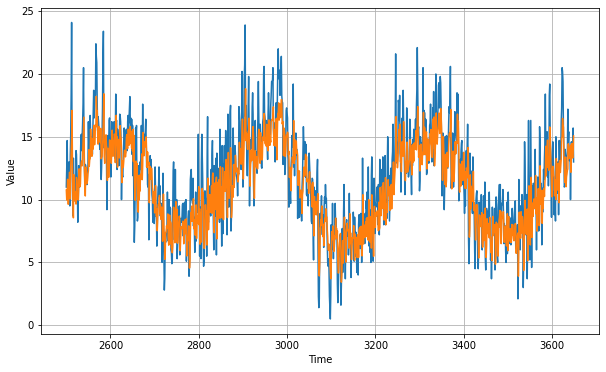

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8799866

In [0]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[10.760231   9.966553  10.660313  ... 13.309878  13.586527  15.0673685]


<Figure size 432x288 with 0 Axes>

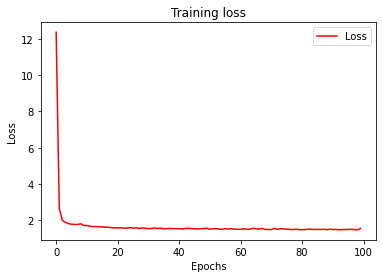

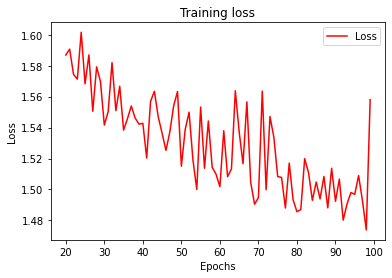

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[20:]
zoomed_epochs = range(20,100)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()